### Prediction Nueral Network | Keras Framework
- [Article Link](https://www.kaggle.com/youssefhesham8/chrun-bank-data-with-simple-ann)
- [Keras](https://keras.io/api/models/sequential/)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import shap
from tensorflow.keras import models, layers, utils, backend as K
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shap
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv(r'E:\random_data\Churn_Modelling.csv')
print('\nDateframe Shape: ', {df.shape})

df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace=True)

for i in df.columns:
    if i != 'CreditScore':
       print(f"{i} -> {df[i].unique()}")

df['Gender'] = df['Gender'].replace({'Male':1 , 'Female':0})
df = pd.get_dummies(data = df, columns=['Geography'])

for i in df.columns:
    if i != 'CreditScore':
       print(f"{i} -> {df[i].unique()}")


Dateframe Shape:  {(10000, 14)}
Geography -> ['France' 'Spain' 'Germany']
Gender -> ['Female' 'Male']
Age -> [42 41 39 43 44 50 29 27 31 24 34 25 35 45 58 32 38 46 36 33 40 51 61 49
 37 19 66 56 26 21 55 75 22 30 28 65 48 52 57 73 47 54 72 20 67 79 62 53
 80 59 68 23 60 70 63 64 18 82 69 74 71 76 77 88 85 84 78 81 92 83]
Tenure -> [ 2  1  8  7  4  6  3 10  5  9  0]
Balance -> [     0.    83807.86 159660.8  ...  57369.61  75075.31 130142.79]
NumOfProducts -> [1 3 2 4]
HasCrCard -> [1 0]
IsActiveMember -> [1 0]
EstimatedSalary -> [101348.88 112542.58 113931.57 ...  42085.58  92888.52  38190.78]
Exited -> [1 0]
Gender -> [0 1]
Age -> [42 41 39 43 44 50 29 27 31 24 34 25 35 45 58 32 38 46 36 33 40 51 61 49
 37 19 66 56 26 21 55 75 22 30 28 65 48 52 57 73 47 54 72 20 67 79 62 53
 80 59 68 23 60 70 63 64 18 82 69 74 71 76 77 88 85 84 78 81 92 83]
Tenure -> [ 2  1  8  7  4  6  3 10  5  9  0]
Balance -> [     0.    83807.86 159660.8  ...  57369.61  75075.31 130142.79]
NumOfProducts -> [1 3 2 

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Gender,10000.0,0.545700,0.497932,0.00,0.00,1.000,1.0000,1.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


<AxesSubplot:xlabel='Balance'>

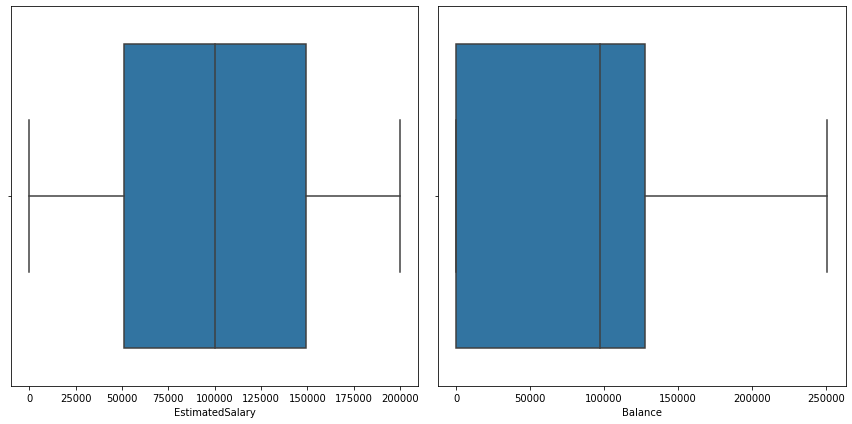

In [4]:
plt.rcParams["figure.figsize"] = [12,6] 
plt.rcParams["figure.autolayout"] = True 

fig, axes = plt.subplots(1, 2)
sns.boxplot(x = df['EstimatedSalary'], ax = axes[0],  showfliers = True)  
sns.boxplot(x = df['Balance'] , ax = axes[1], showfliers = True )

In [5]:
scale = Normalizer()
lis = ['Age','CreditScore' , 'Balance', 'EstimatedSalary']
df[lis] = scale.fit_transform(df[lis])
df.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,0.006108,0,0.000414,2,0.000000,1,1,1,0.999981,1,1,0,0
1,0.004333,0,0.000292,1,0.597258,1,0,1,0.802037,0,0,0,1
2,0.002559,0,0.000214,8,0.814000,3,1,0,0.580859,1,1,0,0


In [10]:
sam = SMOTE(sampling_strategy='minority')

X = df.drop('Exited', axis = 1)
Y = df['Exited']

x_smote, y_smote = sam.fit_resample(X,Y)
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote,test_size= 0.25, stratify= y_smote)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience=3),
    tf.keras.callbacks.CSVLogger('model_logger.csv', separator = ",", append=False),
    tf.keras.callbacks.TensorBoard(log_dir= './logs'),
]

def model_nn(x_train, x_test, y_train, y_test):

    mod = keras.Sequential([
        keras.layers.Dense(5000, input_dim = len(x_train.columns), activation = 'relu'),
        keras.layers.Dense(1000, activation = 'relu'),
        keras.layers.Dense(500, activation = 'sigmoid'),
        keras.layers.Dense(1, activation = 'sigmoid'),
    ])
    
    mod.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    
    mod.fit(x_train, y_train, epochs = 100, verbose = 0, callbacks = [my_callbacks])
    
    print(f'\n test accuracy -> {mod.evaluate(x_test, y_test)}')

    y_pred = mod.predict(x_test)
    y_pred = np.round(y_pred)
    
    return y_pred

y_pred = model_nn(x_train, x_test, y_train, y_test)

125/125 [==============================] - 1s 8ms/step - loss: 0.5134 - accuracy: 0.7785

 test accuracy -> [0.5134021043777466, 0.7785032391548157]


report               precision    recall  f1-score   support

           0       0.79      0.75      0.77      1991
           1       0.76      0.80      0.78      1991

    accuracy                           0.78      3982
   macro avg       0.78      0.78      0.78      3982
weighted avg       0.78      0.78      0.78      3982



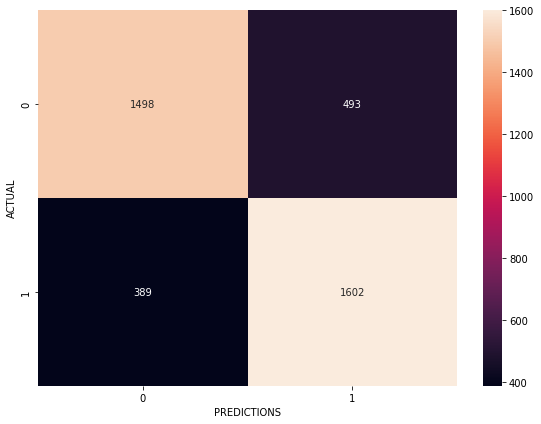

In [11]:
con = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)
print(f'report {classification_report(y_test, y_pred)}')

plt.figure(figsize=(8,6))
sns.heatmap(con, annot = True, fmt = "d")
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUAL")
plt.show()

In [16]:
sam_2 = SMOTE(sampling_strategy='minority')

X = df.drop('Exited', axis = 1)
Y = df['Exited']

x_smote_2, y_smote_2 = sam_2.fit_resample(X, Y)
x_train, x_test, y_train, y_test = train_test_split(x_smote_2, y_smote_2, test_size = 0.25, stratify = y_smote)

N_FEATURES = len(x_train.columns)

model = models.Sequential(name="DeepNN", layers=[
    layers.Dense(name="h1", input_dim=N_FEATURES,
                 units=int(round((N_FEATURES+1)/2)), 
                 activation='relu'),
    layers.Dropout(name="drop1", rate=0.2),
    layers.Dense(name="h2", units=int(round((N_FEATURES+1)/4)), 
                 activation='relu'),
#    layers.Dropout(name="drop2", rate=0.2),
    layers.Dense(name="output", units=1, activation='sigmoid')
])

model.summary()

'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "DeepNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 6)                 78        
                                                                 
 drop1 (Dropout)             (None, 6)                 0         
                                                                 
 h2 (Dense)                  (None, 3)                 21        
                                                                 
 output (Dense)              (None, 1)                 4         
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


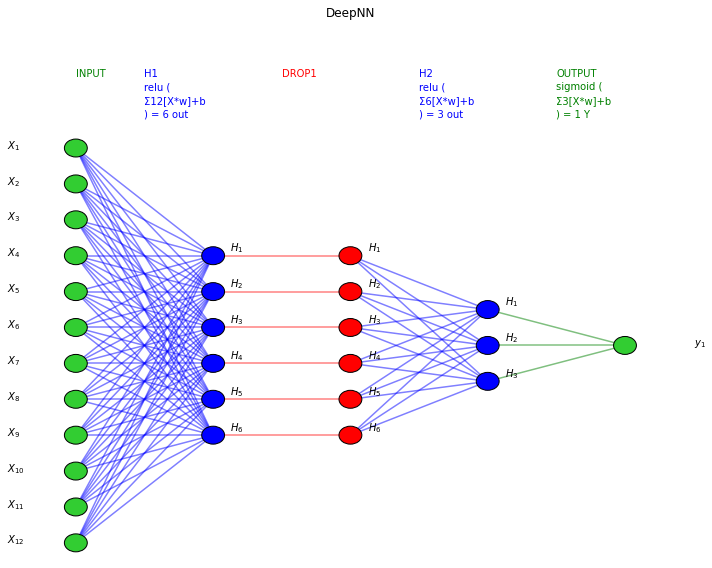

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [15]:
visualize_nn(model, description=True, figsize=(10,8))

utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [17]:
my_callbacks_2 = [
    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5),
    tf.keras.callbacks.CSVLogger('model_logger_2.csv', separator = ",", append=False),
#    tf.keras.callbacks.TensorBoard(log_dir= './logs'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

training = model.fit(x_train, y_train, batch_size = 32, epochs = 50, shuffle = True, verbose = 0, validation_split = 0.2, callbacks = [my_callbacks_2])

print(f'\n test accuracy -> {model.evaluate(x_test, y_test)}')
print('COMPLETED')

125/125 [==============================] - 0s 1ms/step - loss: 0.5911 - accuracy: 0.6891

 test accuracy -> [0.5910900235176086, 0.689100980758667]
COMPLETED


report               precision    recall  f1-score   support

           0       0.70      0.65      0.68      1991
           1       0.68      0.73      0.70      1991

    accuracy                           0.69      3982
   macro avg       0.69      0.69      0.69      3982
weighted avg       0.69      0.69      0.69      3982



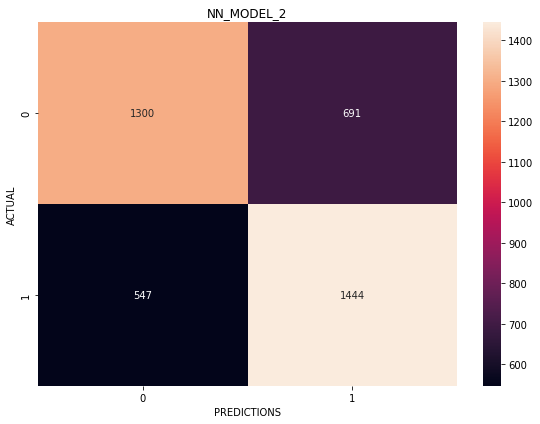

In [20]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

con_2 = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)
print(f'report {classification_report(y_test, y_pred)}')

plt.figure(figsize=(8,6))
sns.heatmap(con_2, annot = True, fmt = "d")
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUAL")
plt.title("NN_MODEL_2")
plt.show()

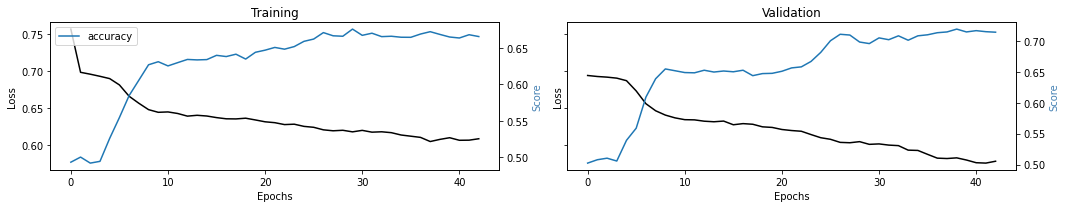

In [21]:
# plot
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))

## training    
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
 
for metric in metrics:        
    ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

## validation    
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')

for metric in metrics:          
    ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
plt.show()